In [111]:
import xarray as xr
import plotnine as pn
import pandas as pd
import numpy as np

In [112]:
snakemake_input = dict(
        offshore_deep_awe="build/capacity_factors/capacity_factors_offshore_deep_awe.nc",
        offshore_shallow_awe="build/capacity_factors/capacity_factors_offshore_shallow_awe.nc",
        old_wind_offshore="build/capacity_factors/capacity_factors_old_wind-offshore.nc",
        old_wind_onshore="build/capacity_factors/capacity_factors_old_wind-onshore.nc",
        onshore_awe="build/capacity_factors/capacity_factors_onshore_awe.nc"
)

In [113]:
capacity_factors = {}
for name, path_capacity_factors in snakemake_input.items():
    ds = xr.load_dataset("../"+path_capacity_factors)
    ds = ds.rename({"__xarray_dataarray_variable__": name})
    capacity_factors[name] = ds

In [31]:
pd.concat([ds.to_dataframe() for ds in capacity_factors.values()], axis=1)

offshore_deep_awe  offshore_shallow_awe  \
time                id                                               
2013-01-01 00:00:00 3               0.489407              0.425388   
                    6               0.995567              0.983617   
                    15              0.220752              0.172057   
                    135             0.938065              0.911791   
                    136             0.761444              0.821176   
...                                      ...                   ...   
2018-12-31 23:00:00 SVN_1                NaN                   NaN   
                    SWE_1                NaN                   NaN   
                    SWE_2                NaN                   NaN   
                    SWE_3                NaN                   NaN   
                    SWE_4                NaN                   NaN   

                           old_wind_offshore  old_wind_onshore  onshore_awe  
time                id                                                       
2013-01-01 00:00:00 3                    NaN               NaN          NaN  
                    6                    NaN               NaN          NaN  
                    15                   NaN               NaN          NaN  
                    135                  NaN               NaN          NaN  
                    136                  NaN               NaN          NaN  
...                                      ...               ...          ...  
2018-12-31 23:00:00 SVN_1           0.199167          0.212685     0.418064  
                    SWE_1           0.847032          0.289147     0.459573  
                    SWE_2           0.847032          0.445979     0.914586  
                    SWE_3           0.847032          0.785747     0.999996  
                    SWE_4           0.847032          0.898823     1.000000  

[9361128 rows x 5 columns]

In [118]:
ds_cf = pd.concat([i.to_dataframe().groupby("time").agg(lambda x: x.mean(skipna=False)) for key, i in capacity_factors.items()], axis=1)
rename_dict = {"onshore_awe": "AWE onshore", "offshore_shallow_awe": "AWE offshore shallow ", "offshore_deep_awe": "AWE offshore deep ", "old_wind_onshore": "Conventional wind onshore", "old_wind_offshore": "Conventional wind offshore"}
ds_cf = ds_cf.rename(columns=rename_dict)
ds_cf  = ds_cf[rename_dict.values()]
ds_cf.head()

,AWE onshore,AWE offshore shallow,AWE offshore deep,Conventional wind onshore,Conventional wind offshore
time,,,,,
2010-01-01 00:00:00,NaN,NaN,NaN,0.378424,0.386146
2010-01-01 01:00:00,NaN,NaN,NaN,0.380985,0.385134
2010-01-01 02:00:00,NaN,NaN,NaN,0.384114,0.384922
2010-01-01 03:00:00,NaN,NaN,NaN,0.387595,0.387168
2010-01-01 04:00:00,NaN,NaN,NaN,0.394606,0.391073


/home/jlauner/.conda/envs/jw4a-d2.1/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 78912 rows containing non-finite values.


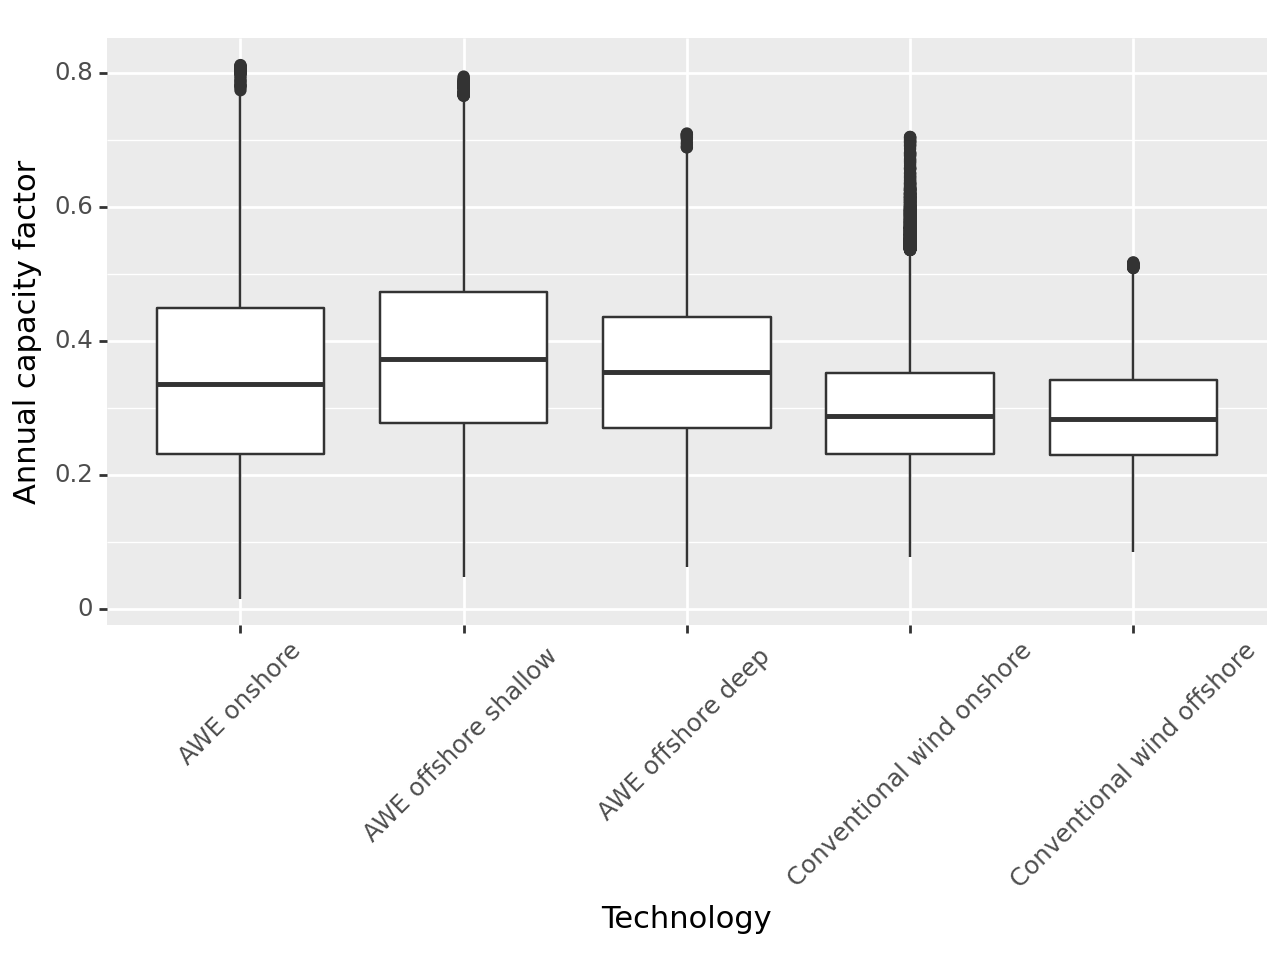

In [115]:
# Prepare data
data = ds_cf.melt()
data["variable"] = pd.Categorical(data["variable"], ds_cf.columns)

# Create boxplot
boxplot = (
    pn.ggplot(data, pn.aes(x='variable', y='value'))
    + pn.geom_boxplot()
    + pn.labs(x='Technology', y='Annual capacity factor')
    + pn.theme(axis_text_x=pn.element_text(angle=45))
    # + pn.stat_summary(
    #     geom='text', 
    #     fun_y=np.mean, 
    #     mapping=pn.aes(label='mean'), 
    #     va='bottom', 
    #     size=10
    # )
    # + geom_text(aes(label=pn.after_stat('summary')), stat = 'summary')
)
print(boxplot)

/home/jlauner/.conda/envs/jw4a-d2.1/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 78912 rows containing non-finite values.


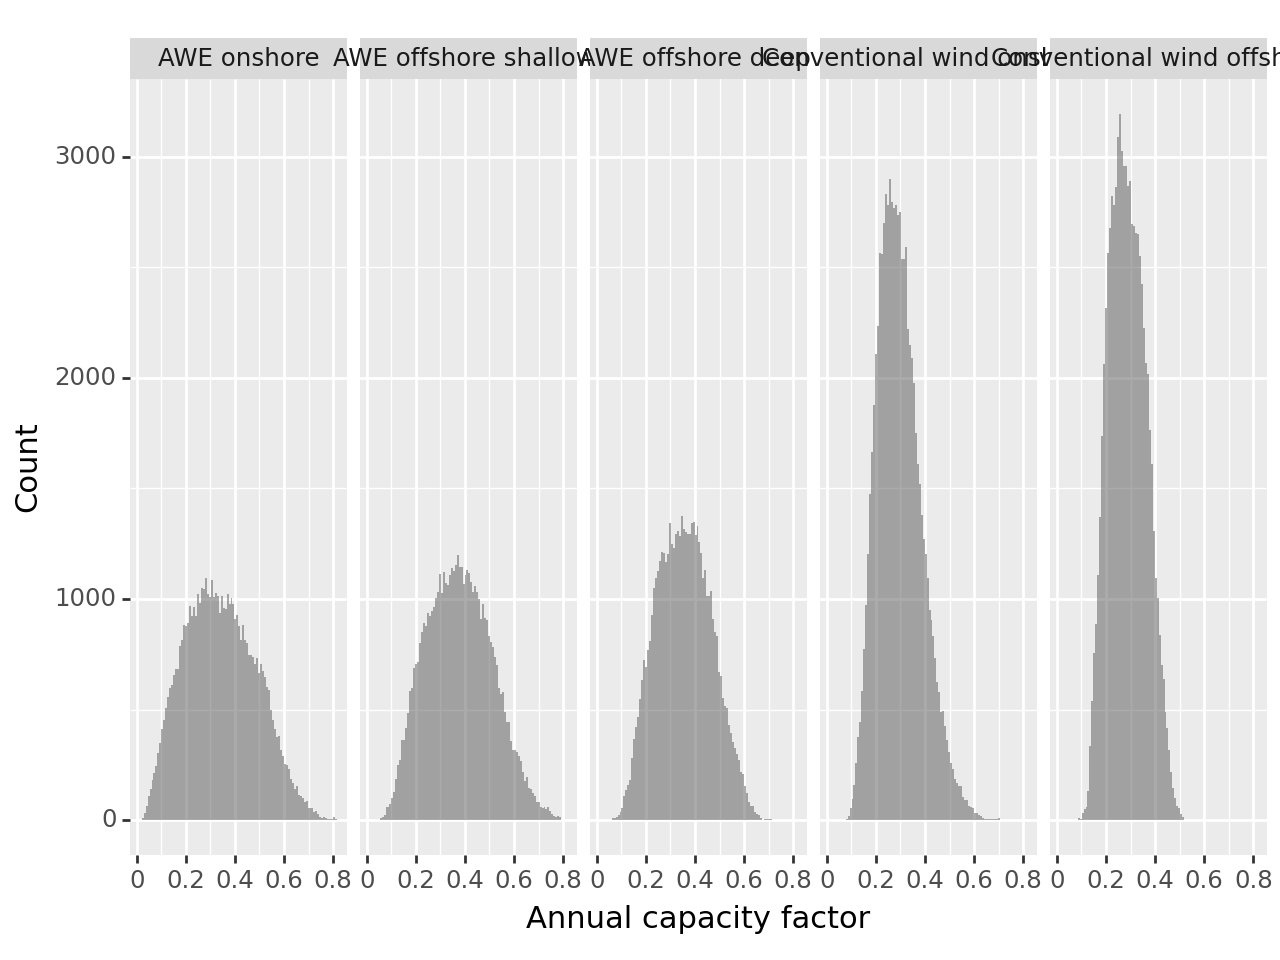

In [116]:
# Prepare data
data = ds_cf.melt()
data["variable"] = pd.Categorical(data["variable"], ds_cf.columns)
import matplotlib.pyplot as plt

# Create histogram
histogram = (
    pn.ggplot(data, pn.aes(x='value', group='variable'))
    + pn.facet_wrap("variable", nrow=4, ncol=8)
    + pn.geom_histogram(alpha=0.5, bins=100)
    + pn.labs(x='Annual capacity factor', y='Count')
    + pn.theme(legend_position='top')
)
print(histogram)


- Why is the median of AWE deep lower than the one for offshore shallow?
- Q: Why is the median of conventional wind offshore not higher than onshore?
    - A: There are quite a lot of zeros in the offshore timeseries, which is suspicious. Maybe there are all-zero regions which I should drop first?
    - There are many all zero-regions: ['AUT_1', 'AUT_2', 'AUT_3', 'CHE_1', 'CHE_2', 'CZE_1', 'CZE_2', 'DEU_3',
       'DEU_4', 'DEU_5', 'DEU_6', 'DEU_7', 'ESP_3', 'ESP_5', 'ESP_7', 'ESP_8',
       'FRA_10', 'FRA_11', 'FRA_12', 'FRA_14', 'FRA_5', 'FRA_6', 'FRA_7',
       'HUN_1', 'LUX_1', 'MKD_1', 'POL_1', 'POL_2', 'POL_3', 'ROU_1', 'ROU_2',
       'SRB_1', 'SVK_1']
- These are averaged over regions, but the shown distribution is over time!
- Plot histograms for a given region.

In [41]:
old = ["old_wind_onshore", "old_wind_offshore"]
df = pd.concat([cf.to_dataframe() for name, cf in capacity_factors.items() if name in old], axis=1)


old_wind_offshore  old_wind_onshore
time                id                                        
2010-01-01 00:00:00 ALB_1           0.796485          0.557766
                    AUT_1           0.000000          0.028939
                    AUT_2           0.000000          0.106498
                    AUT_3           0.000000          0.170122
                    BEL_1           0.825077          0.304748
...                                      ...               ...
2018-12-31 23:00:00 SVN_1           0.199167          0.212685
                    SWE_1           0.847032          0.289147
                    SWE_2           0.847032          0.445979
                    SWE_3           0.847032          0.785747
                    SWE_4           0.847032          0.898823

[7731024 rows x 2 columns]

In [43]:
df = df.reset_index()
df = df.melt(id_vars=["time", "id"])
df

,time,id,variable,value
0,2010-01-01 00:00:00,ALB_1,old_wind_offshore,0.796485
1,2010-01-01 00:00:00,AUT_1,old_wind_offshore,0.000000
2,2010-01-01 00:00:00,AUT_2,old_wind_offshore,0.000000
3,2010-01-01 00:00:00,AUT_3,old_wind_offshore,0.000000
4,2010-01-01 00:00:00,BEL_1,old_wind_offshore,0.825077
...,...,...,...,...
15462043,2018-12-31 23:00:00,SVN_1,old_wind_onshore,0.212685
15462044,2018-12-31 23:00:00,SWE_1,old_wind_onshore,0.289147
15462045,2018-12-31 23:00:00,SWE_2,old_wind_onshore,0.445979
15462046,2018-12-31 23:00:00,SWE_3,old_wind_onshore,0.785747


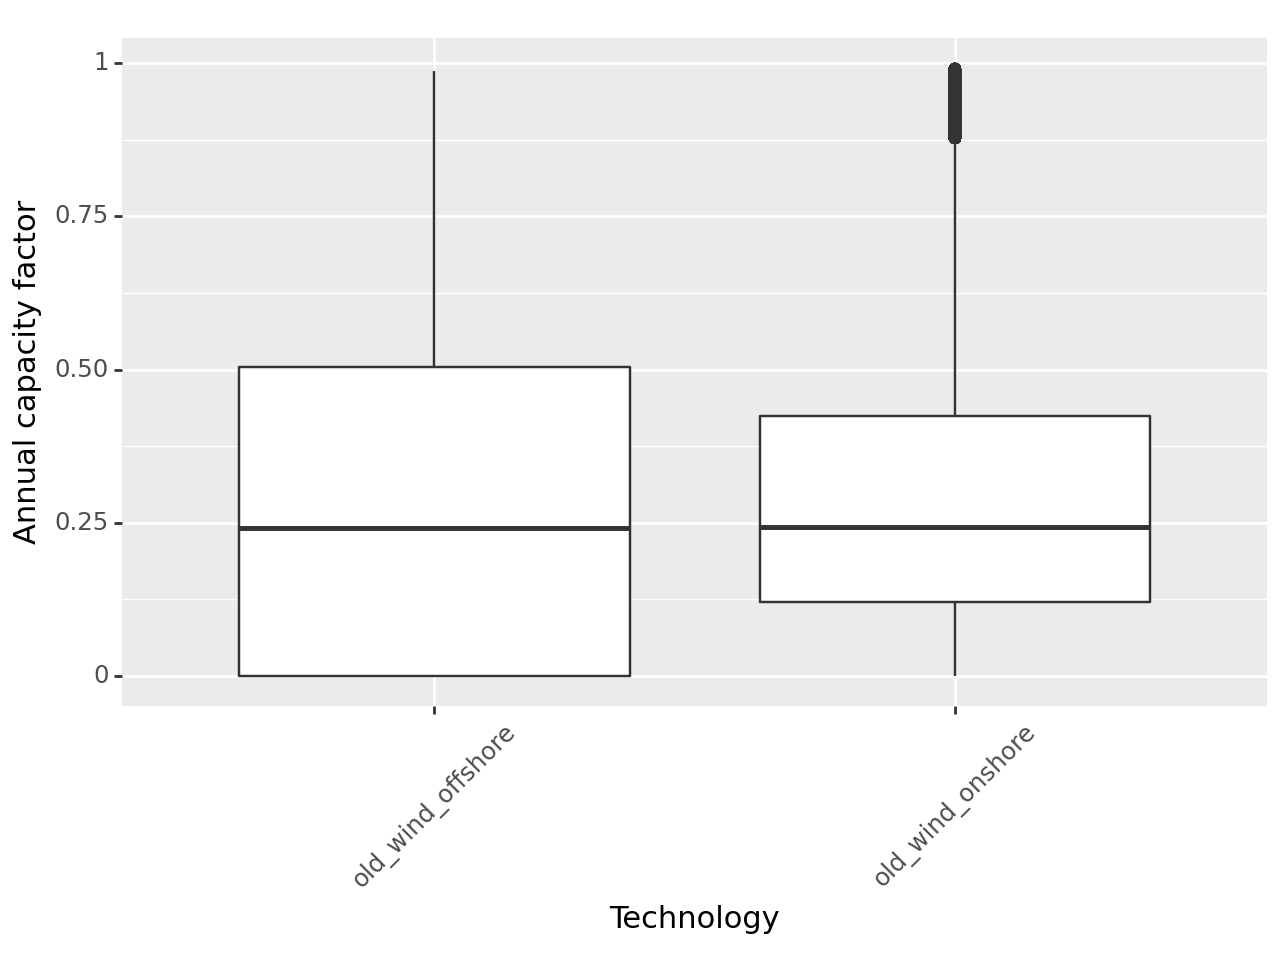

In [45]:

boxplot = (
    pn.ggplot(df, pn.aes(x='variable', y='value'))
    + pn.geom_boxplot()
    + pn.labs(x='Technology', y='Annual capacity factor')
    + pn.theme(axis_text_x=pn.element_text(angle=45))
    # + pn.stat_summary(
    #     geom='text', 
    #     fun_y=np.mean, 
    #     mapping=pn.aes(label='mean'), 
    #     va='bottom', 
    #     size=10
    # )
    # + geom_text(aes(label=pn.after_stat('summary')), stat = 'summary')
)
print(boxplot)

In [100]:
df.loc[df.id == "ALB_1"]

,time,id,variable,value
0,2010-01-01 00:00:00,ALB_1,old_wind_offshore,0.796485
98,2010-01-01 01:00:00,ALB_1,old_wind_offshore,0.758475
196,2010-01-01 02:00:00,ALB_1,old_wind_offshore,0.709051
294,2010-01-01 03:00:00,ALB_1,old_wind_offshore,0.647806
392,2010-01-01 04:00:00,ALB_1,old_wind_offshore,0.610921
...,...,...,...,...
15461558,2018-12-31 19:00:00,ALB_1,old_wind_onshore,0.484391
15461656,2018-12-31 20:00:00,ALB_1,old_wind_onshore,0.512883
15461754,2018-12-31 21:00:00,ALB_1,old_wind_onshore,0.542949
15461852,2018-12-31 22:00:00,ALB_1,old_wind_onshore,0.567378


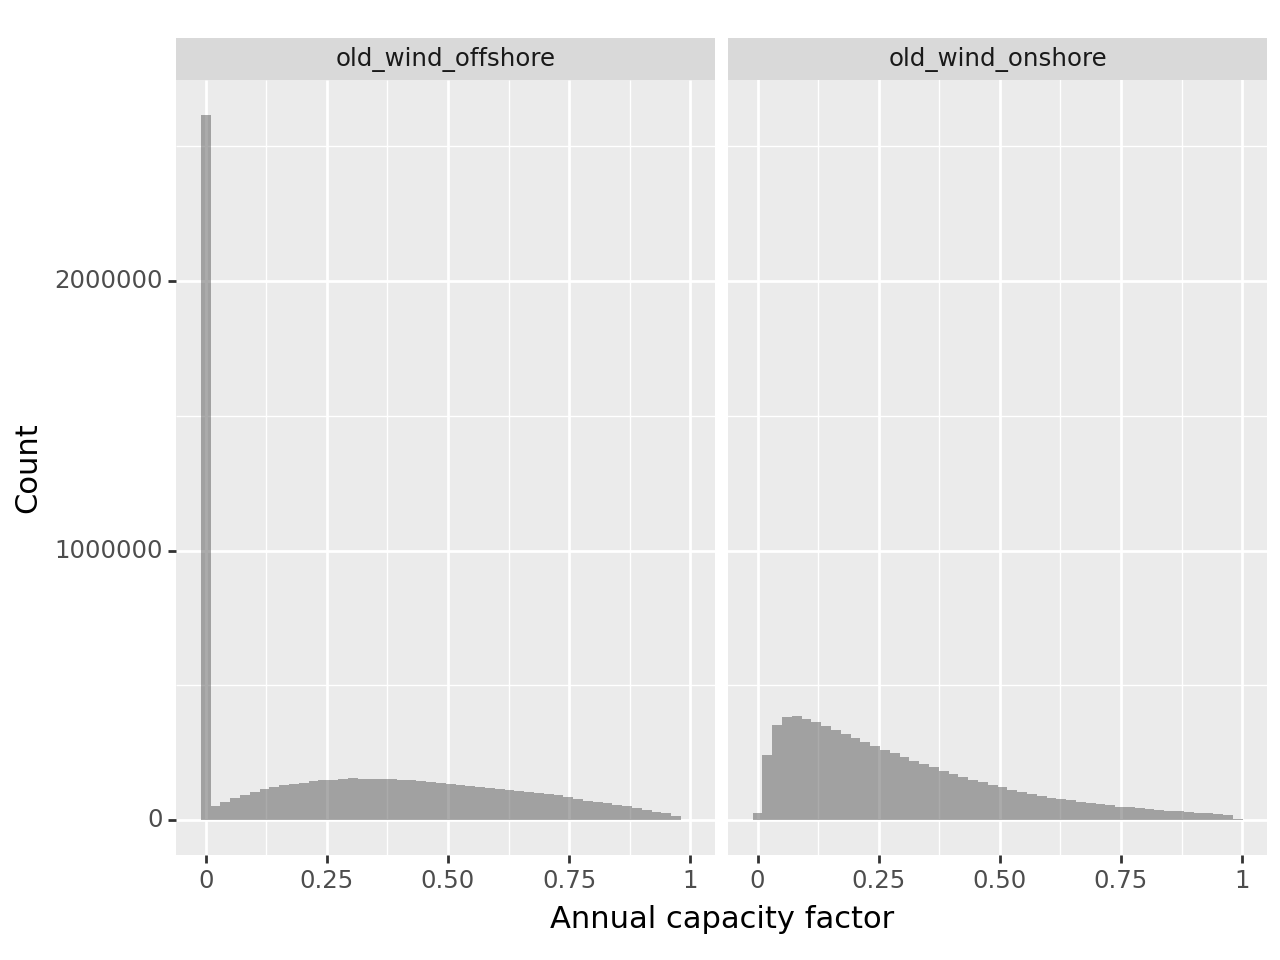

In [134]:
histogram = (
    pn.ggplot(df, pn.aes(x='value', group='variable'))
    + pn.facet_wrap("variable", nrow=4, ncol=8)
    + pn.geom_histogram(alpha=0.5, bins=50)
    + pn.labs(x='Annual capacity factor', y='Count')
    + pn.theme(legend_position='top')
)
print(histogram)

In [128]:
df_pivot = pd.pivot_table(df, index="time", columns=["variable", "id"], values="value")

small = (df_pivot < 0.03).sum(axis=0) / (df_pivot < 1).sum(axis=0)
df_filtered = df_pivot.drop(columns=small.loc[small > 0.90].index)

In [130]:
df_filtered

variable            old_wind_offshore                                          \
id                              ALB_1     BEL_1     BGR_1     BIH_1     CYP_1   
time                                                                            
2010-01-01 00:00:00          0.796485  0.825077  0.606697  0.636728  0.231889   
2010-01-01 01:00:00          0.758475  0.829843  0.619898  0.581954  0.220222   
2010-01-01 02:00:00          0.709051  0.838531  0.681457  0.515555  0.210793   
2010-01-01 03:00:00          0.647806  0.859977  0.738759  0.469044  0.207831   
2010-01-01 04:00:00          0.610921  0.877379  0.767916  0.467627  0.221357   
...                               ...       ...       ...       ...       ...   
2018-12-31 19:00:00          0.635035  0.411243  0.109453  0.785061  0.216811   
2018-12-31 20:00:00          0.649275  0.418091  0.135148  0.797245  0.248175   
2018-12-31 21:00:00          0.663572  0.428239  0.160259  0.797971  0.272635   
2018-12-31 22:00:00          0.672075  0.457245  0.183528  0.796452  0.287325   
2018-12-31 23:00:00          0.663076  0.492414  0.215982  0.792886  0.295524   

variable                                                               ...  \
id                      DEU_1     DEU_2     DNK_1     DNK_2     ESP_1  ...   
time                                                                   ...   
2010-01-01 00:00:00  0.474247  0.474247  0.177461  0.177461  0.810637  ...   
2010-01-01 01:00:00  0.450936  0.450936  0.164870  0.164870  0.806651  ...   
2010-01-01 02:00:00  0.417684  0.417684  0.156245  0.156245  0.796441  ...   
2010-01-01 03:00:00  0.390473  0.390473  0.157169  0.157169  0.783849  ...   
2010-01-01 04:00:00  0.371671  0.371671  0.172281  0.172281  0.780531  ...   
...                       ...       ...       ...       ...       ...  ...   
2018-12-31 19:00:00  0.838108  0.838108  0.904798  0.904798  0.327927  ...   
2018-12-31 20:00:00  0.871959  0.871959  0.916804  0.916804  0.326493  ...   
2018-12-31 21:00:00  0.902816  0.902816  0.931835  0.931835  0.322936  ...   
2018-12-31 22:00:00  0.923620  0.923620  0.944909  0.944909  0.315020  ...   
2018-12-31 23:00:00  0.943011  0.943011  0.956362  0.956362  0.305771  ...   

variable            old_wind_onshore                                          \
id                             ROU_1     ROU_2     ROU_3     SRB_1     SVK_1   
time                                                                           
2010-01-01 00:00:00         0.483262  0.173450  0.117590  0.572624  0.193126   
2010-01-01 01:00:00         0.483915  0.191438  0.136926  0.606554  0.172246   
2010-01-01 02:00:00         0.476292  0.239429  0.161674  0.628941  0.153674   
2010-01-01 03:00:00         0.508578  0.335886  0.202475  0.636012  0.146402   
2010-01-01 04:00:00         0.568560  0.455005  0.267369  0.633549  0.132194   
...                              ...       ...       ...       ...       ...   
2018-12-31 19:00:00         0.158284  0.085063  0.093799  0.221986  0.432268   
2018-12-31 20:00:00         0.145976  0.104611  0.084955  0.225235  0.386059   
2018-12-31 21:00:00         0.133163  0.130718  0.078863  0.230338  0.309329   
2018-12-31 22:00:00         0.122072  0.169967  0.078717  0.239136  0.240590   
2018-12-31 23:00:00         0.109494  0.214102  0.088733  0.243541  0.172519   

variable                                                               
id                      SVN_1     SWE_1     SWE_2     SWE_3     SWE_4  
time                                                                   
2010-01-01 00:00:00  0.075190  0.280856  0.305496  0.196287  0.184094  
2010-01-01 01:00:00  0.095666  0.274809  0.334560  0.219760  0.187664  
2010-01-01 02:00:00  0.129767  0.261409  0.331154  0.236091  0.192704  
2010-01-01 03:00:00  0.153946  0.238657  0.346194  0.240414  0.198865  
2010-01-01 04:00:00  0.149700  0.230944  0.364915  0.250434  0.209659  
...                       ...       ...       ...       ...       ...  
201

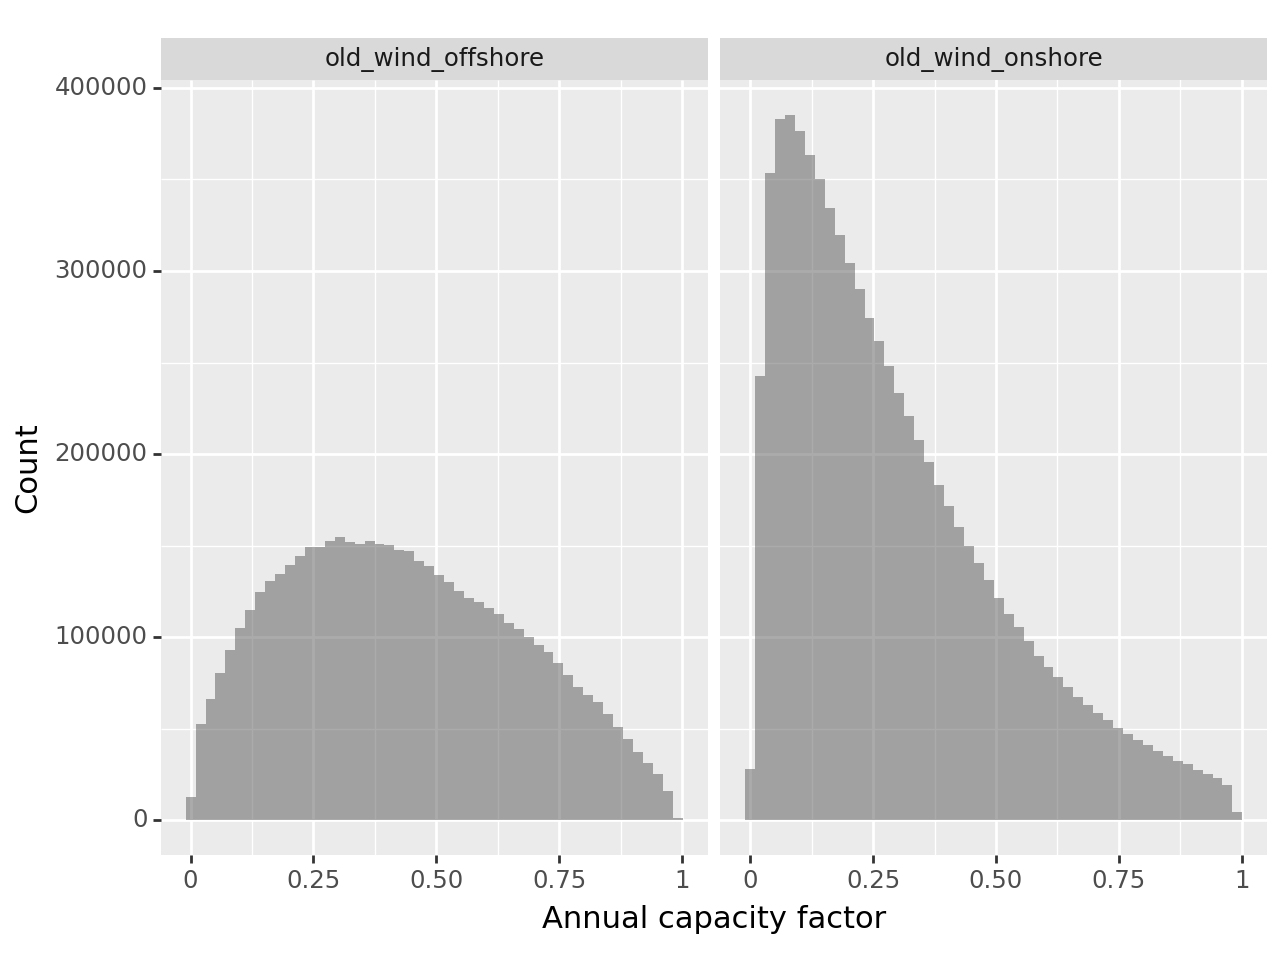

In [136]:
df_no_small = pd.melt(df_filtered)
histogram = (
    pn.ggplot(df_no_small, pn.aes(x='value', group='variable'))
    + pn.facet_wrap("variable", nrow=4, ncol=8)
    + pn.geom_histogram(alpha=0.5, bins=50)
    + pn.labs(x='Annual capacity factor', y='Count')
    + pn.theme(legend_position='top')
)
print(histogram)

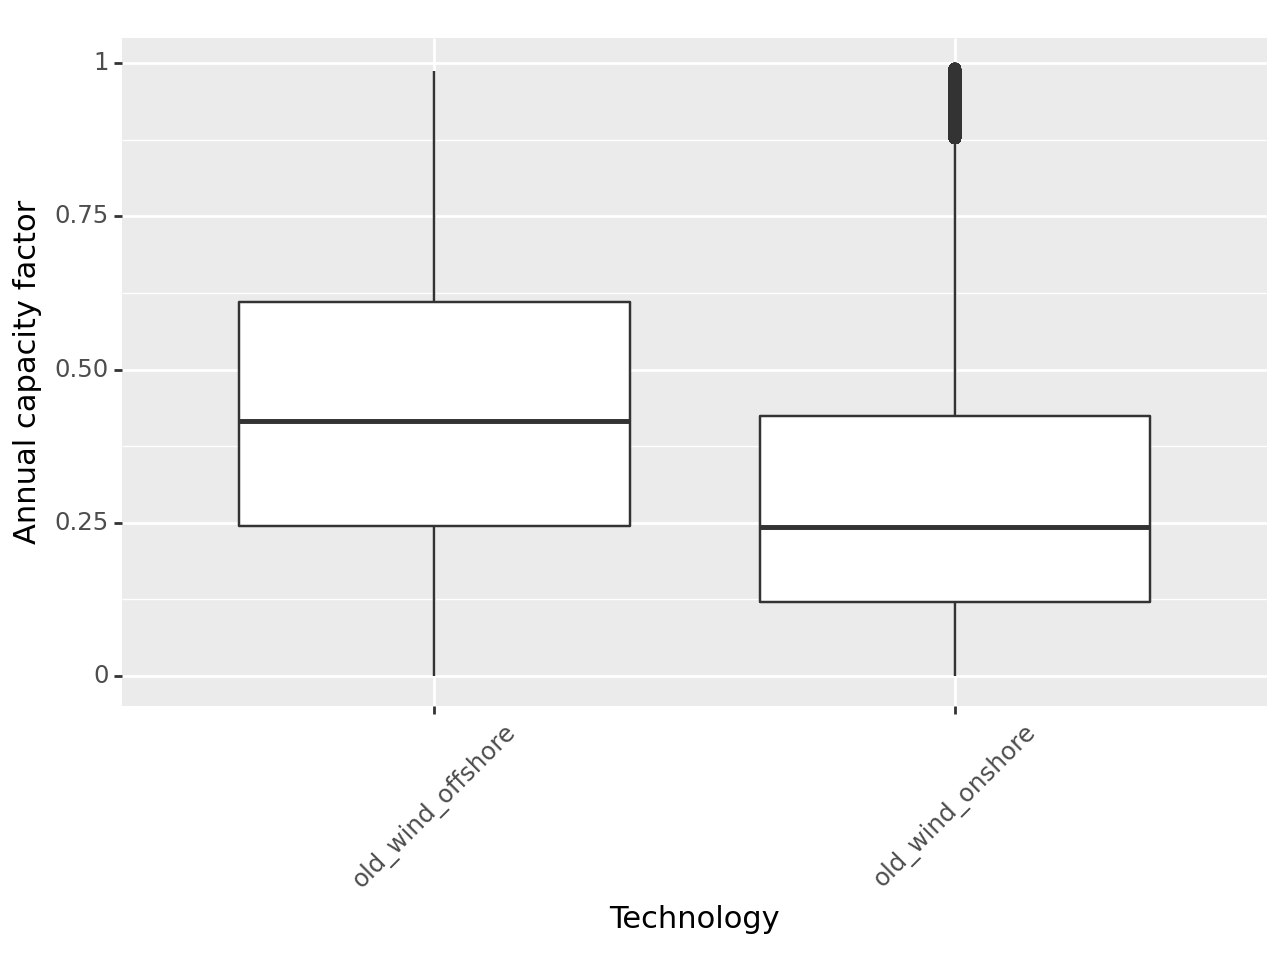

In [137]:

boxplot = (
    pn.ggplot(df_no_small, pn.aes(x='variable', y='value'))
    + pn.geom_boxplot()
    + pn.labs(x='Technology', y='Annual capacity factor')
    + pn.theme(axis_text_x=pn.element_text(angle=45))
)
print(boxplot)

In [159]:
new = ["offshore_deep_awe", "offshore_shallow_awe"]
df_new = pd.concat([cf.to_dataframe() for name, cf in capacity_factors.items() if name in new], axis=1)

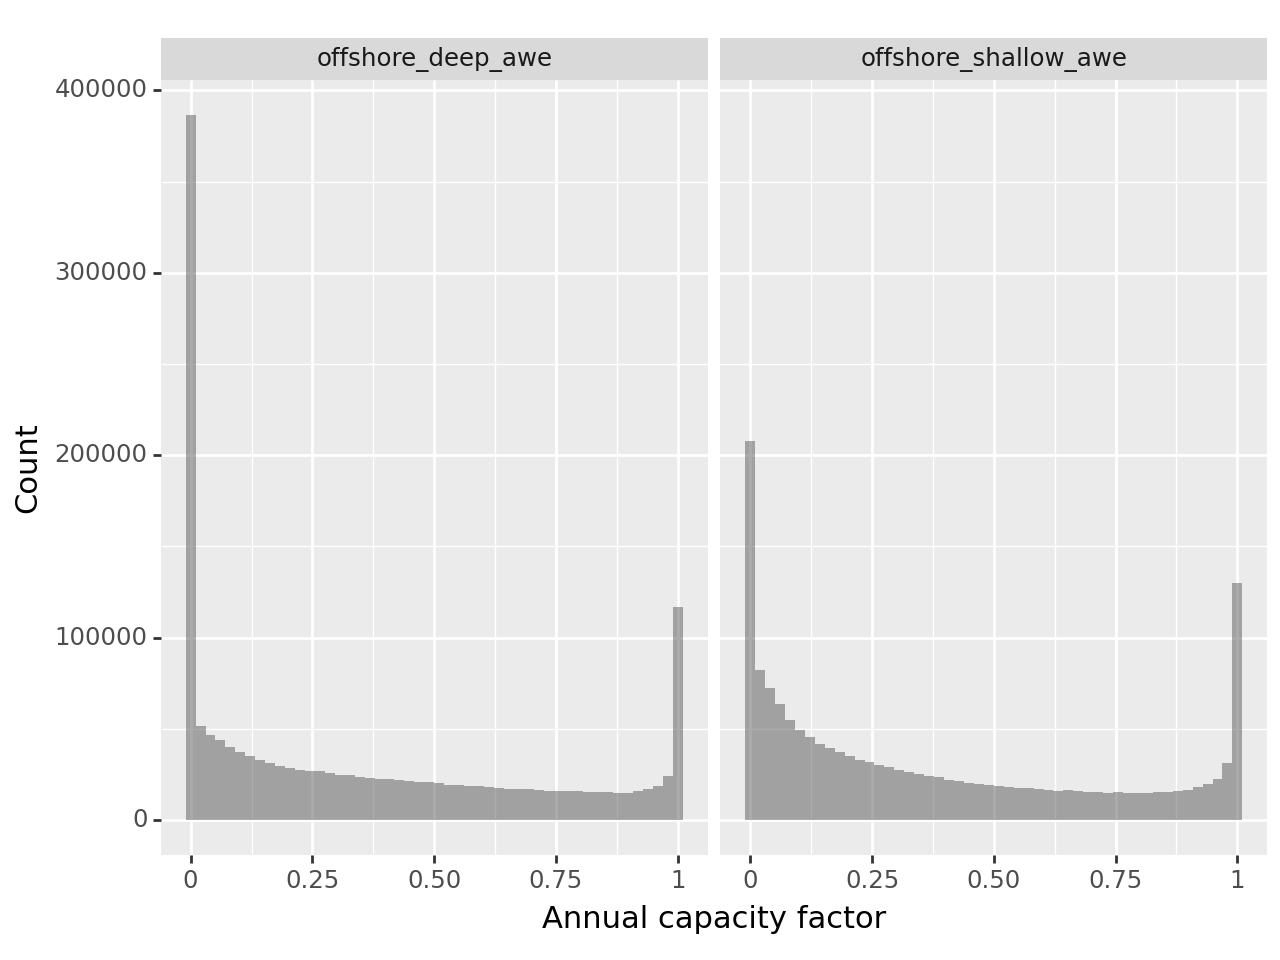

In [160]:
histogram = (
    pn.ggplot(df_new.melt(), pn.aes(x='value', group='variable'))
    + pn.facet_wrap("variable", nrow=4, ncol=8)
    + pn.geom_histogram(alpha=0.5, bins=50)
    + pn.labs(x='Annual capacity factor', y='Count')
    + pn.theme(legend_position='top')
)
print(histogram)

In [164]:
df_new

offshore_deep_awe  offshore_shallow_awe
time                id                                          
2013-01-01 00:00:00 3             0.489407              0.425388
                    6             0.995567              0.983617
                    15            0.220752              0.172057
                    135           0.938065              0.911791
                    136           0.761444              0.821176
...                                    ...                   ...
2018-12-31 23:00:00 261           0.538453              0.874196
                    262           1.000000              1.000000
                    263           0.560874              0.463824
                    276           0.261948              0.164182
                    280           0.509157              0.775848

[1630104 rows x 2 columns]

In [192]:
df_new_pivot = df_new.unstack("id")
df_new_pivot


offshore_deep_awe                                          \
id                                  3         6        15       135       136   
time                                                                            
2013-01-01 00:00:00          0.489407  0.995567  0.220752  0.938065  0.761444   
2013-01-01 01:00:00          0.508882  0.998839  0.223447  0.994917  0.779830   
2013-01-01 02:00:00          0.514570  0.999645  0.229657  1.000000  0.823611   
2013-01-01 03:00:00          0.481502  0.999451  0.234205  1.000000  0.882046   
2013-01-01 04:00:00          0.444438  0.999621  0.246633  0.998891  0.933059   
...                               ...       ...       ...       ...       ...   
2018-12-31 19:00:00          0.318471  0.432095  0.676748  0.601654  0.344159   
2018-12-31 20:00:00          0.321258  0.383020  0.700779  0.584433  0.791046   
2018-12-31 21:00:00          0.323352  0.339008  0.723905  0.547426  0.999741   
2018-12-31 22:00:00          0.371029  0.289255  0.840440  0.456308  0.984427   
2018-12-31 23:00:00          0.336360  0.232236  0.835814  0.396859  0.956061   

                                                        ...  \
id                   142  143  152       158       160  ...   
time                                                    ...   
2013-01-01 00:00:00  0.0  0.0  0.0  0.045518  0.000000  ...   
2013-01-01 01:00:00  0.0  0.0  0.0  0.041313  0.000000  ...   
2013-01-01 02:00:00  0.0  0.0  0.0  0.039824  0.000000  ...   
2013-01-01 03:00:00  0.0  0.0  0.0  0.040105  0.000000  ...   
2013-01-01 04:00:00  0.0  0.0  0.0  0.042224  0.000000  ...   
...                  ...  ...  ...       ...       ...  ...   
2018-12-31 19:00:00  0.0  0.0  0.0  0.553374  0.001192  ...   
2018-12-31 20:00:00  0.0  0.0  0.0  0.562326  0.005803  ...   
2018-12-31 21:00:00  0.0  0.0  0.0  0.574311  0.014087  ...   
2018-12-31 22:00:00  0.0  0.0  0.0  0.591985  0.039237  ...   
2018-12-31 23:00:00  0.0  0.0  0.0  0.647925  0.051479  ...   

                    offshore_shallow_awe                                \
id                                   256       257       258       259   
time                                                                     
2013-01-01 00:00:00             1.000000  1.000000  1.000000  0.803054   
2013-01-01 01:00:00             1.000000  1.000000  1.000000  0.750567   
2013-01-01 02:00:00             1.000000  1.000000  0.999654  0.769264   
2013-01-01 03:00:00             1.000000  1.000000  0.959609  0.740936   
2013-01-01 04:00:00             1.000000  1.000000  0.730148  0.615380   
...                                  ...       ...       ...       ...   
2018-12-31 19:00:00             0.922422  1.000000  0.282220  0.906469   
2018-12-31 20:00:00             0.999734  1.000000  0.319340  0.922694   
2018-12-31 21:00:00             1.000000  1.000000  0.360420  0.934001   
2018-12-31 22:00:00             1.000000  0.114001  0.562056  0.980629   
2018-12-31 23:00:00             1.000000  0.000000  0.558918  0.984634   

                                                                       \
id                        260       261       262       263       276   
time                                                                    
2013-01-01 00:00:00  0.826433  0.898174  1.000000  0.003826  0.895811   
2013-01-01 01:00:00  0.740998  0.854218  1.000000  0.002438  0.901358   
2013-01-01 02:00:00  0.658135  0.786192  1.000000  0.000371  0.916168   
2013-01-01 03:00:00  0.665468  0.778591  1.000000  0.000784  0.924031   
2013-01-01 04:00:00  0.639080  0.783250  1.000000  0.001038  0.918644   
...                       ...       ...       ...       ...       ...   
2018-12-31 19:00:00  0.999923  1.000000  0.995472  0.263141  0.164285   
2018-12-31 20:00:00  0.999992  0.999990  0.999982  0.314104  0.168295   
2018-12-31 21:00:00  0.999997  0.998232  1.000000  0.358464  0.176016   
2018-12-31 22:00:00  0.999992  0.969707  1.000000  0.376823  0.179767   
2018-12-31 23:00

In [193]:

small_new = (df_new_pivot < 0.03).sum(axis=0) / (df_new_pivot < 1).sum(axis=0)
small_new.loc[small_new > 0.90].index
df_new_filtered = df_new_pivot.drop(columns=small_new.loc[small_new > 0.90].index)

df_plot =df_new_filtered.reset_index().melt(id_vars=["time"])
df_plot.columns = ["time", "variable", "id", "value"]

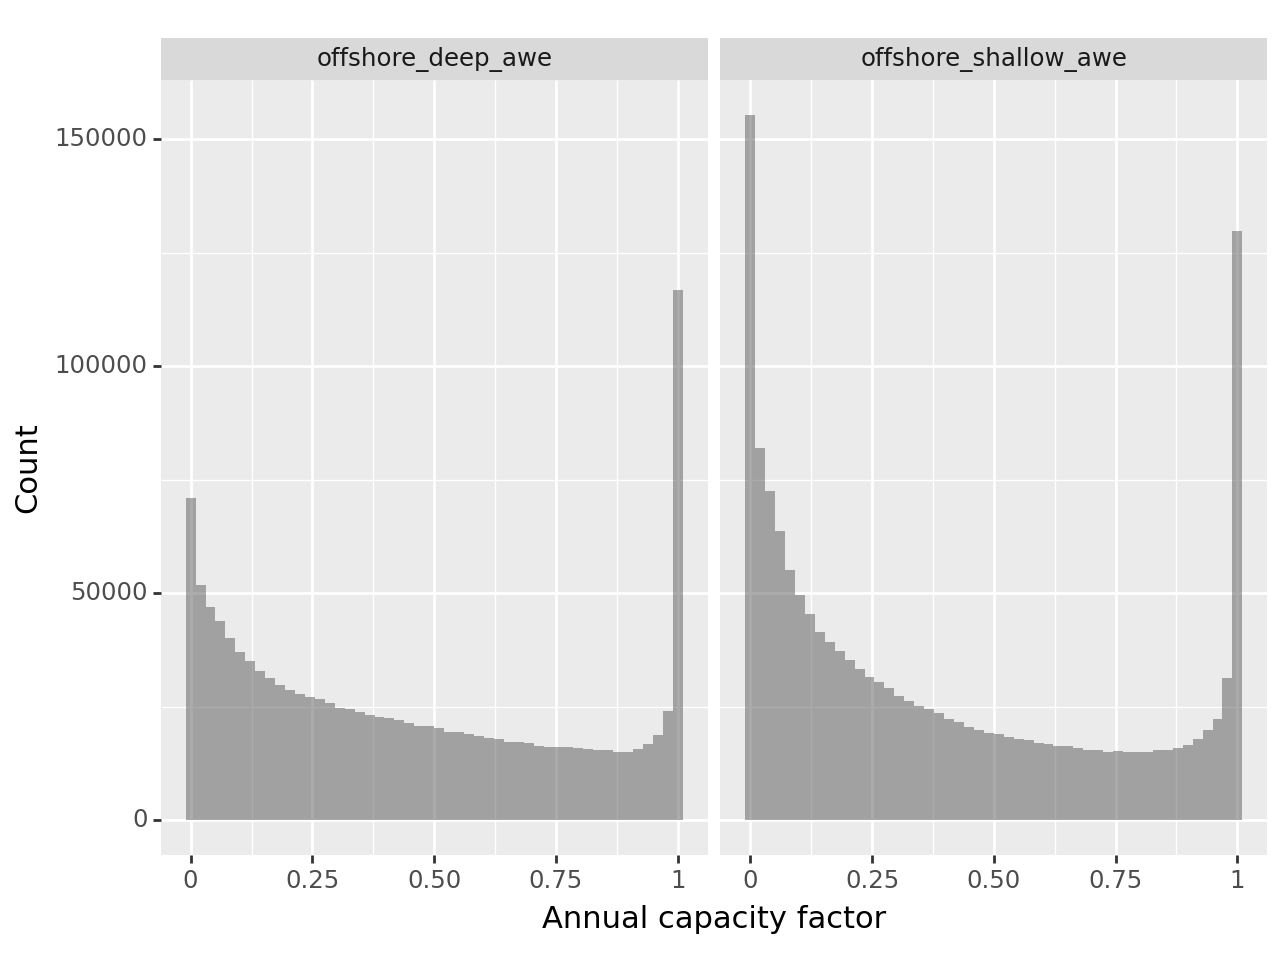

In [194]:

histogram = (
    pn.ggplot(df_plot, pn.aes(x='value', group='variable'))
    + pn.facet_wrap("variable", nrow=4, ncol=8)
    + pn.geom_histogram(alpha=0.5, bins=50)
    + pn.labs(x='Annual capacity factor', y='Count')
    + pn.theme(legend_position='top')
)
print(histogram)

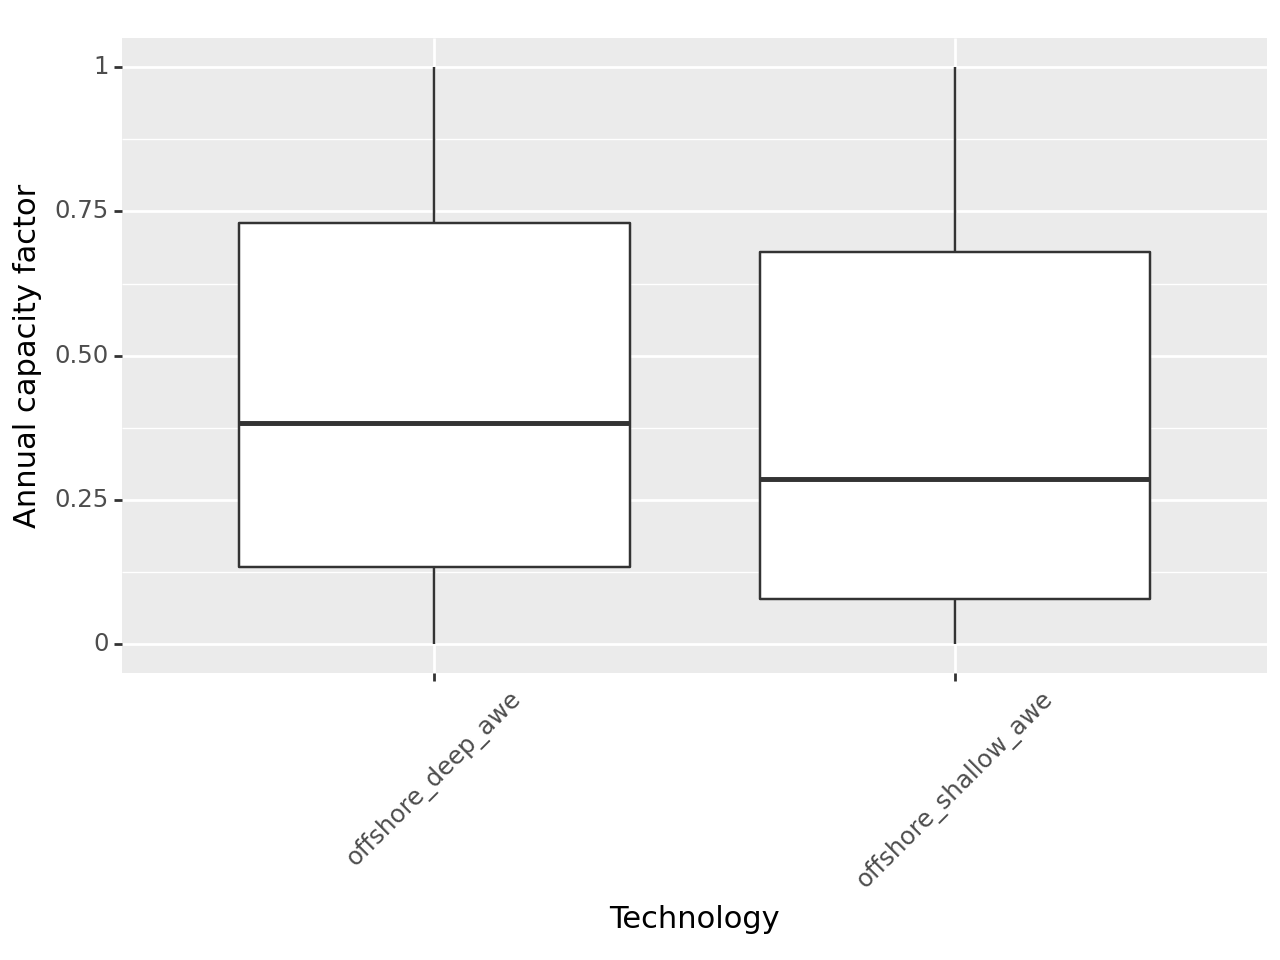

In [195]:

boxplot = (
    pn.ggplot(df_plot, pn.aes(x='variable', y='value'))
    + pn.geom_boxplot()
    + pn.labs(x='Technology', y='Annual capacity factor')
    + pn.theme(axis_text_x=pn.element_text(angle=45))
)
print(boxplot)